In [47]:
from typing import Tuple

import numpy as np
import torch
import torchvision
import torch.nn as nn

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
image_folder = "bloodcells_dataset"
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256, 256))
    ]
)
dataset = torchvision.datasets.ImageFolder(image_folder, transform=data_transforms)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(train, batch_size=32)
test_loader = torch.utils.data.DataLoader(test, batch_size=32)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


In [76]:
class CNN(nn.Module):
    def __init__(self, image_size: Tuple[int, int, int]):
        super(CNN, self).__init__()
        self.image_size = image_size
        self.conv1 = nn.Conv2d(in_channels=self.image_size[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_line_size = int(64 * (image_size[1]//8) * (image_size[2]//8))
        self.fc1 = nn.Linear(in_features=self.linear_line_size, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=8)


    def forward(self, x):
        # print(f'start {x.size()}')
        x = self.conv1(x)
        # print(f'conv1 {x.size()}')
        x = nn.functional.relu(x)
        x = self.pool1(x)
        # print(f'pool1 {x.size()}')
        x = self.conv2(x)
        # print(f'conv2 {x.size()}')
        x = nn.functional.relu(x)
        x = self.pool2(x)
        # print(f'pool2 {x.size()}')
        x = self.conv3(x)
        # print(f'conv3 {x.size()}')
        x = nn.functional.relu(x)
        x = self.pool3(x)
        # print(f'pool3 {x.size()}')
        x = x.view(x.size(0), -1)
        # print(f'flat {x.size()}')
        x = nn.functional.dropout(x, p=0.2)
        # print(f'dropout {x.size()}')
        x = self.fc1(x)
        # print(f'fc1 {x.size()}')
        x = nn.functional.relu(x)
        x = self.fc2(x)
        # print(f'fc2 {x.size()}')
        return x

In [77]:
def train_cnn(n_epochs: int, image_size: Tuple[int, int, int]):
    model = CNN(image_size=image_size)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, )
    
    for epoch in range(n_epochs):
        for i, (inputs, targets) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device)).squeeze()
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

    return model

In [78]:
def eval_model(model, image_size: Tuple[int, int, int]):
    criterion = nn.CrossEntropyLoss()
    model.eval()  

    total_loss = 0
    correct_predictions = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    mean_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / len(test_loader.dataset)

    print(f'Test Loss: {mean_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2%}')

    return all_targets, all_predictions


In [79]:
model = train_cnn(n_epochs=5, image_size=[3, 256, 256])

Epoch [1/5], Step [10/428], Loss: 1.9848
Epoch [1/5], Step [20/428], Loss: 2.0461
Epoch [1/5], Step [30/428], Loss: 2.1130
Epoch [1/5], Step [40/428], Loss: 2.0242
Epoch [1/5], Step [50/428], Loss: 1.9625
Epoch [1/5], Step [60/428], Loss: 1.8723
Epoch [1/5], Step [70/428], Loss: 1.4755
Epoch [1/5], Step [80/428], Loss: 1.2563
Epoch [1/5], Step [90/428], Loss: 1.1158
Epoch [1/5], Step [100/428], Loss: 1.3160
Epoch [1/5], Step [110/428], Loss: 1.2903
Epoch [1/5], Step [120/428], Loss: 0.9340
Epoch [1/5], Step [130/428], Loss: 1.0203
Epoch [1/5], Step [140/428], Loss: 0.9014
Epoch [1/5], Step [150/428], Loss: 1.1297
Epoch [1/5], Step [160/428], Loss: 0.7687
Epoch [1/5], Step [170/428], Loss: 1.2854
Epoch [1/5], Step [180/428], Loss: 0.8804
Epoch [1/5], Step [190/428], Loss: 1.0862
Epoch [1/5], Step [200/428], Loss: 1.0613
Epoch [1/5], Step [210/428], Loss: 0.9500
Epoch [1/5], Step [220/428], Loss: 0.7030
Epoch [1/5], Step [230/428], Loss: 0.8838
Epoch [1/5], Step [240/428], Loss: 1.0876
E

In [80]:
def plot_confusion_matrix(targets, predictions, class_names):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 0.1985
Test Accuracy: 93.33%


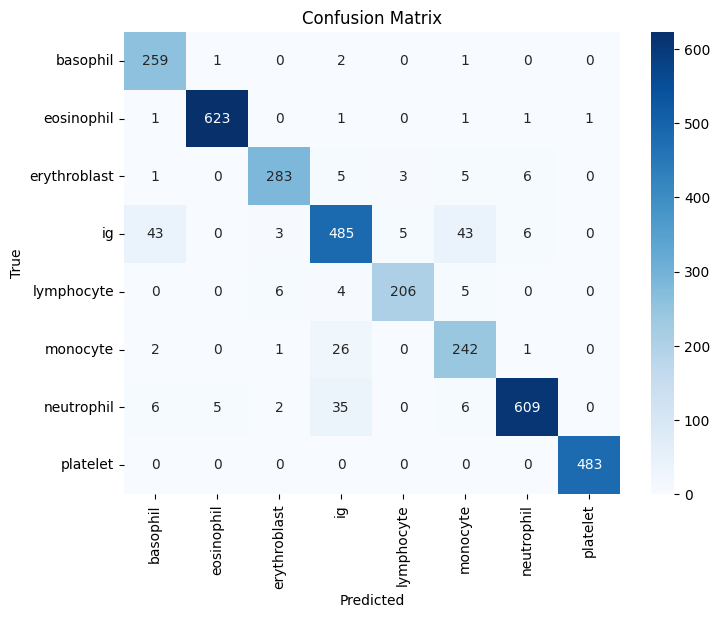

In [82]:
class_names = dataset.classes  # Assuming `dataset` is your `ImageFolder`
all_targets, all_predictions = eval_model(model, image_size=(3, 256, 256))
plot_confusion_matrix(all_targets, all_predictions, class_names)